In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras import metrics
from keras import optimizers
from math import *

Using TensorFlow backend.


In [2]:
class app:
    def __init__(self):
        conn = sqlite3.connect('stockData.db')
        c = conn.cursor()

        self.dataBase = conn.execute('select * from stockData')
        self.indices = [description[0] for description in self.dataBase.description][1:]
        
        c.execute('SELECT COUNT(*) FROM stockdata') 
        
        self.vertical = c.fetchone()[0]
        
        c.execute('SELECT * FROM stockdata') 

        self.data = np.zeros((self.vertical, len(self.indices)))
        self.size = 0
        
        self.budget = 10000
    
        self.gottenData = False
    
    def getTimestamps(self):
        conn = sqlite3.connect('stockData.db')
        c = conn.cursor()
        
        c.execute('SELECT timestamp FROM stockdata')
        return c.fetchall()

    
    def add(self, x):
            self.data[self.size] = x[1:]
            self.size += 1
            
    def getData(self):
        toolbar_width = 100

        for row in self.dataBase:
            self.add(row)
            if self.size % (self.vertical // 100) == 0:
                length = int(self.size // (self.vertical // 100))
                remainder = int(100 - length)
                clear_output()
                sys.stdout.write("[")
                sys.stdout.write("-" * length)
                sys.stdout.write(" " * remainder)
                sys.stdout.write("]")
                sys.stdout.write(str(length) + "%")
                sys.stdout.flush()
                
        sys.stdout.write("\n")
        self.gottenData = True
    
    def price(self, ticker):
        return self.prices[self.indices.index(ticker)]
    
    def sell(self, ticker, volume=1):
        if self.shares[self.indices.index(ticker)] >= volume:
            self.fbudget += self.price(ticker)*volume
            self.shares[self.indices.index(ticker)] = self.shares[self.indices.index(ticker)] - volume 
    
    def buy(self, ticker, volume=1):
        if self.fbudget - self.price(ticker)*volume >= 0:
            self.fbudget -= self.price(ticker)*volume
            self.shares[self.indices.index(ticker)] = self.shares[self.indices.index(ticker)] + volume 
    
    def trade(self, algorithm, start = 0, detail = 100):
        
        self.values = {}
        
        self.shares = [0] * len(self.indices)
        
        self.fbudget = self.budget
        
        count = 0
        
        vertical = len(data[start:])
        
        print(vertical)
        
        self.values["algorithm"] = [None] * (vertical//detail)
        self.values["spy"] = [None] * (vertical//detail)
        
        for row in self.data[start:]:
            self.prices = row
            algorithm()
        
            if count % (vertical // detail) == 0:
                
                if count == 0:
                    self.ospy = self.price("SPY")
                length = int(count // (vertical // detail))
                remainder = int(detail - length)
                clear_output()
                sys.stdout.write("[")
                sys.stdout.write("-" * length)
                sys.stdout.write(" " * remainder)
                sys.stdout.write("]")
                sys.stdout.write(str(length) + "%")
                sys.stdout.flush()
                self.end(count // detail)
                
                nth = int(count/(vertical//detail))
                
                self.values["algorithm"][nth], self.values["spy"][nth] = self.value()
            
            count += 1 
        
    
    def value(self):
        
        spy = self.price("SPY")/self.ospy
        total = self.fbudget
        
        for index, value in enumerate(self.shares):
            total += value * self.price(self.indices[index])
        
        total =  total/self.budget
        
        return total, spy
        
    
    def end(self, num):
        plt.ion()
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(self.values["algorithm"][:num], label = "Algorithm")
        line2, = ax1.plot(self.values["spy"][:num], label = "S&P 500")
        plt.legend(loc='upper left')
        plt.show()

In [3]:
trader = app()

In [4]:
trader.getData()

data = trader.data

[----------------------------------------------------------------------------------------------------]100%


In [5]:
print(trader.gottenData)

True


In [6]:
n = trader.data.shape[0]
p = trader.data.shape[1]

# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = trader.data[np.arange(train_start, train_end), :]
data_test = trader.data[np.arange(test_start, test_end), :]

y_test = np.array([[log(data_test[i+1][k]/data_test[i][k]) for k in range(len(data_test[i+1]))] for i in range(len(data_test[1:]))])

y_train = np.array([[log(data_train[i+1][k]/data_train[i][k]) for k in range(len(data_train[i+1]))] for i in range(len(data_train[1:]))])


In [ ]:
print(y_test)

In [16]:
xscaler = MinMaxScaler()
xscaler.fit(np.vstack((data_test, data_train)))
X_train = xscaler.transform(data_train)
X_test = xscaler.transform(data_test)

yscaler = MinMaxScaler()
yscaler.fit(np.vstack((y_test, y_train)))
y_train = yscaler.transform(y_train)
y_test = yscaler.transform(y_test)

In [17]:
def makeBatches(batchSize):
    global y_train, X_train
    
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    X_batches = np.array_split(X_train, len(X_train) // batchSize)
    y_batches = np.array_split(y_train, len(y_train) // batchSize)
    
    return X_batches, y_batches

In [18]:
n_stocks = X_train.shape[1]

model = Sequential()
model.add(Dense(units=2*n_stocks + 1, activation='relu', input_dim=n_stocks))
model.add(Dense(units=2*n_stocks+1, activation='relu'))
model.add(Dense(units=n_stocks))

optimizer = optimizers.adam()


model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
nepochs = 2
batchSize = 512
batch_losses = []

for i in range(nepochs):
    X_batches, y_batches = makeBatches(batchSize)
    batch_losses += [model.train_on_batch(X_batches[i], y_batches[i]) for i in range(len(X_batches))]
    print(i)

plt.plot(batch_losses)
plt.show()

In [ ]:
model.save_weights("model.h5")

In [19]:
model.load_weights("model.h5")

[----------------------------------------------------------------------------------------------------]100%

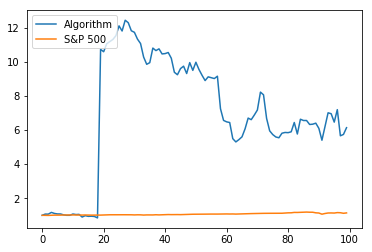

531.7941257953644


In [91]:
trader = app()

trader.budget = 10000
trader.data = data

print(type(trader.data))

def algorithm():
    
    X = xscaler.transform(np.array(trader.prices).reshape(1, -1))
    pred = yscaler.inverse_transform(model.predict(X))[0]
    
    indices = [k for k,v in enumerate(trader.shares) if v > 0]

    stockPreds = [pred[k] for k in indices]

    for k,v in enumerate(stockPreds):
        if k < 0:
            trader.sell(trader.indices[indices[k]], volume = trader.shares[indices[k]])
    
    if max(pred) > 0:
        trader.buy(trader.indices[np.where(pred == max(pred))[0][0]], volume = 100)

start = time.time()

trader.trade(algorithm, start = 0)

end = time.time()

print(end-start)

In [ ]:
print(trader.getTimestamps()[int(np.floor(0.8*n))])

In [ ]:
def graph(arr, graph = "test"):
    arr = arr.reshape(1, -1)[0]
    if graph == "test":
        plot = []
        temp = open_test
        
        for i in arr:
            temp = temp*i
            plot.append(temp)
    
        return plot
    
    if graph == "train":
        plot = []
        temp = open_train
        
        for i in arr:
            temp = temp*i
            plot.append(temp)
        
        return plot
        
def MAPD(F, A):
    temp = 0
    for i in range(len(A)):
        temp += abs((A[i]-F[i][0])/A[i])
    MAPD = temp/len(A)
    
    return MAPD
    